# Neural Networks 7

## Advanced sequential processing

Our previous examples were online sequential processing, recurrency, where a network outputs a new output for every time step. Simultaneosly, it receives a new input at every time step.

$$
y_t = f(x_t,x_{t-1},\ldots)
$$

However, there are tasks where sequence-to-sequence processing does not need to be recurrent, and where the length of input and output are different

$$
\left\{y_0, y_1, \ldots , y_{M-1}\right\} = f(\left\{x_0, x_1, \ldots, x_{N-1}\right\})
$$

Adrej Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) nicely discusses different forms of the input output pairs.

<div>
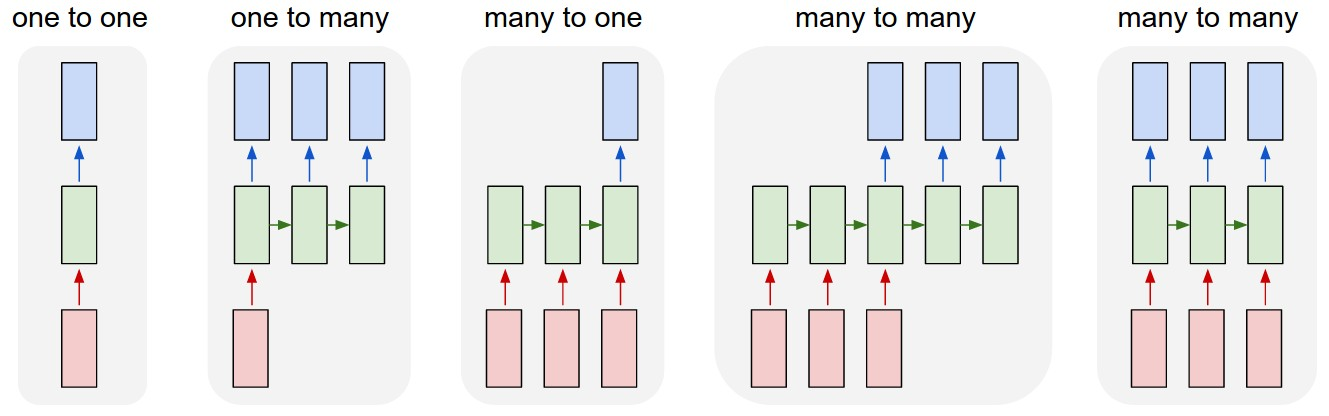
</div>

## Machine translation

Indeed, early ideas such as the LSTM, proposed in

 * S. Hochreiter and J. Schmidhuber (1997): "Long Short-term Memory". In Neural Computation, Vol. 9, No. 8. [PDF](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)
 
did not receive much attention until 15 years later when machine translation (from language A to language B) started to actively look solution from neural networks.

One good read is the following book that describes straight-forward MLP-based implementation of RNNs and the LSTM principle and then provides experimental evidence that LSTM better avoids the vanishing and exploding gradient problems through its forget/remember gates:

 * A. Graves (2012): "Supervised Sequence Labelling with Recurrent Neural Networks". Springer [PDF](https://www.cs.toronto.edu/~graves/preprint.pdf)

Later, the LSTM principle is better explained in this blog post:

 * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### RNN Encoder-Decoder

One of the first attempts was proposed by

 * Kyunghyun Cho, Bart van Merriënboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio (2014): "Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation". In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP). [PDF](https://aclanthology.org/D14-1179.pdf)

<div>
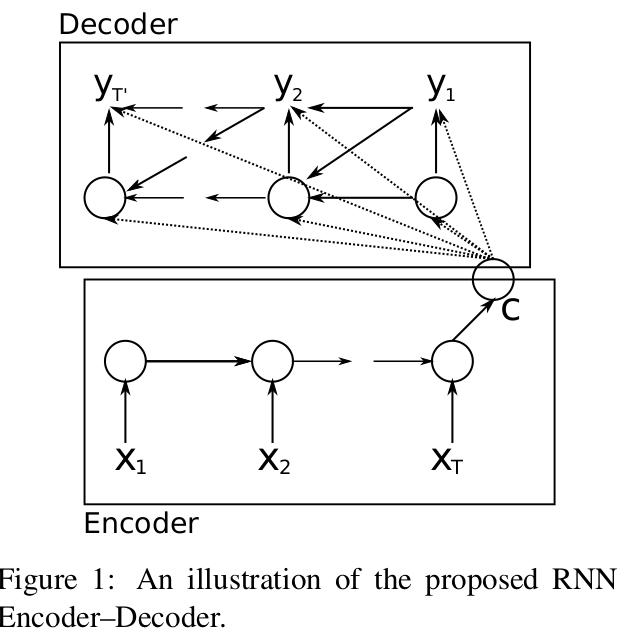
</div>

#### Performance analysis

In their follow-up paper Cho et al. showed that the neural translator performs well on relatively short sentences without too many unknown words (outside the vocabulary and marked as [UNK]), but performance rapidly degrades for longer sentences and more unknown words (their own architecture and LSTM experimented).

 * Kyunghyun Cho, Bart van Merriënboer, Dzmitry Bahdanau, Yoshua Bengio (2014): "On the Properties of Neural Machine Translation: Encoder–Decoder Approaches". In Proceedings of SSST-8, Eighth Workshop on Syntax, Semantics and Structure in Statistical Translation. [PDF](https://aclanthology.org/W14-4012.pdf)




### LSTM Encoder-Decoder

In their milestone paper Sutskever et al. finally introduced an LSTM-based model that outperforms previous non-neural machine translation systems.

 * I. Sutskever, O. Vinyals, and Q.V. Le (2014): "Sequence to Sequence Learning with Neural Networks" in Proc. of the Neural Information Processing Systems (NeurIPS). [PDF](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf)
 

#### Demo: Character-level neural machine translator

Demo is largely copied from:

 * https://keras.io/examples/nlp/lstm_seq2seq/

Load required packages

In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import os
import tensorflow as tf
import keras

Necessary settings

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'Data/fra-eng/fra.txt'

Load the data and convert it to vectors

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, foo = line.split('\t')
    #print(input_text)
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Example input-target pairs:')
print(f'  {input_texts[0]} -> {target_texts[0]}')
print(f'  {input_texts[-1]} -> {target_texts[-1]}')
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

For the tokes we build a dictionary where one integer corresponds to one token (character)

In [ ]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

The input and target dictionaries are used to vectorize the original data for neural network training.

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

print('English input data as same length one-hot-encoded vectors')
print(encoder_input_data.shape)
print('French target data as same length one-hot-encoded vectors')
print(decoder_target_data.shape)

Define the encoder

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Define the decoder

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Define the full model

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Compile and train

In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Save manually

In [ ]:
model.save("s2s-0epochs")

In [ ]:
epochs = 60
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Save model manually

In [ ]:
model.save("s2s-60epochs")

We define sampling models where encoder reads input characther by characther until the end of sentence token appears. Similarly based on the final context of the encoder, the decoder produces characters until it produces the end of sentence token.

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
print(encoder_input_data.shape)

By downloading one of the stored models you can see how the system improves

In [ ]:
model = keras.models.load_model("s2s-61epochs")

Now, let's test the Seq2Seq translator with random sentences from the test data.

In [ ]:
import random

for seq_index in random.sample(range(0,10000),10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

## Attention model

The first paper to propose attention for Neural Machine Translation was

 * Thang Luong, Hieu Pham, Christopher D. Manning (2015): "Effective Approaches to Attention-based Neural Machine Translation". In Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing. [PDF](https://aclanthology.org/D15-1166/)

<div>
 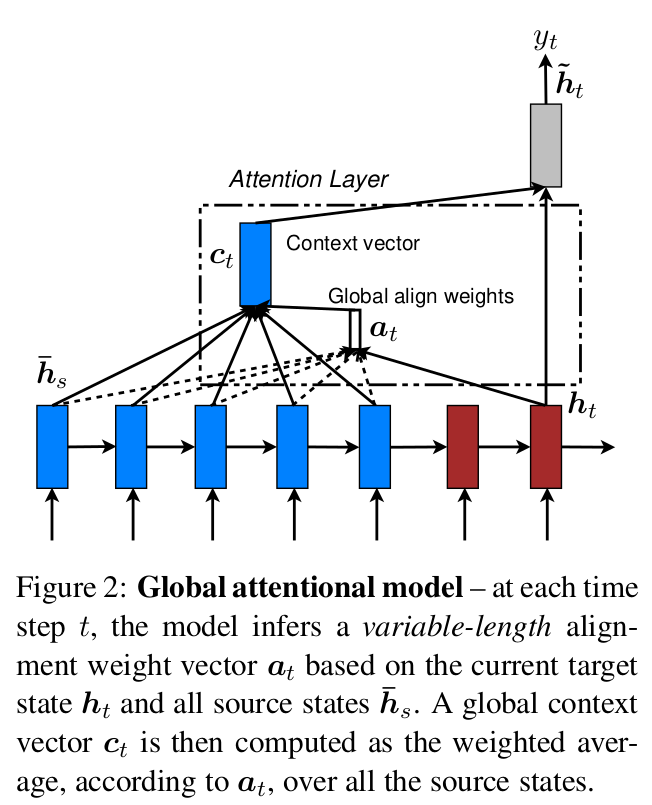
</div>
    
but the same idea was proposed at the same time in

 * D. Bahdanau and K. Cho and Y. Bengio (2015): "Neural Machine Translation by Jointly Learning to Align and Translate". In Proceedings of the International Conference on Learning Representations (ICLR). [PDF](https://arxiv.org/abs/1409.0473)

## Transformers

The Transformer architecture was proposed in

 * Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin (2017): "Attention Is All You Need". In Proceedings of the Neural Information Processing Systems (NeurIPS). [PDF](https://papers.nips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html)
 
It seems that the original idea could be significantly simplified, see, e.g.

 * Hanxiao Liu, Zihang Dai, David R. So, Quoc V. Le (2021): "Pay Attention to MLPs". In the Proceedings of the Advances in Neural Information Processing Systems (NeurIPS). [PDF](https://proceedings.neurips.cc/paper/2021/hash/4cc05b35c2f937c5bd9e7d41d3686fff-Abstract.html)
 
 

#### Demo: Text translator

Code for this demo is taken from the TensorFlow tutorial at, but partly edited

 - https://www.tensorflow.org/text/tutorials/nmt_with_attention
 

** Installing required packages **

tensorflow-text package is sensitive to the other installed packages and their versions. In particular, by March 2023 the Ubuntu conda installed tensorflow and pip installed tensorflow-text do not work together and therefore the both need to use pip install.
 
 ```
 $ conda activate dataml200text
 (dataml200text)$ pip install tensorflow
 (dataml200text)$ pip install tensorflow-text
 (dataml200text)$ python3.8 -m pip install einops
 (dataml200text)$ python3.8 -m pip install shapecheck
 ```

After that you need to create a suitable Jupyter kernel 

 ```
 (dataml200text)$ python3.8 -m ipykernel install --user --name dataml200text --display-name "Python 3.8 (dataml200text)"
 ```

In Jupyter switch to the new kernel and this code should work.

The code was tested using TensorFlow 2.11.0 and Keras 2.11.0.

Import required packages

### Applications

There are many marvelous applications occurring multiple times of each year. Here is the list of them in the chronological order:

 * Transformer (2017) by the Google Brain team - An effective model for Neural Machine Translation.
 * GPT-1 (2018) by OpenAI - Showed that a transformer based generative language pre-training (predict the next word) leads to a strong "backbone" that quickly learns new downstream tasks (set new state-of-the-art in 9 out of tested tasks).
 * GPT-2 (2019) by OpenAI - An improved version of GPT-1 using 1.5 billion parameters.
 * BERT (2020) by Google - Competing model to OpenAI GPT, used in multiple downstream demos
  - Q&A - https://www.pragnakalp.com/demos/BERT-NLP-QnA-Demo/
 * GPT-3 (2020) by OpenAI - A huge model of 150 billion parameters.
 * DALL-E (2021) by OpenAI - Image generation was bound to GPT-3 to generated realistic images from "prompts"
  - Demo: https://gpt3demo.com/apps/openai-dall-e
 * DALL-E 2 (2022) by OpenAI - Improved version
  - Demo: https://openai.com/dall-e-2/
 * ChatGPT (2022) by OpenAI - GPT-3.5 / GPT-4.0 based chatbot that received impressive press coverage
 * GPT-4 (2023) by OpenAI - Can process images and text as inputs, alarmed people about dangerously fast progress in AI.
  - Open letter to stop AI research: https://futureoflife.org/open-letter/pause-giant-ai-experiments/


## References

Theory presented in the following:

 * K. Cho, B. van Merrienboer, C. Gulcehre, D. Bahdanau, F. Bougares, H. Schwenk, Y. Bengio (2014): "Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation" In Proceedings of the Conference on Empirical Methods in Natural Language Processing (EMNLP)  
 
The code here is adapted from the more comprehensive TensorFlow tutorial at:

 * https://www.tensorflow.org/tutorials